In [45]:
!pip install numpy
import numpy as np
import pandas as pd 
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [46]:
train=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [47]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
test=test/255

In [49]:
Y_train  = train.label.values
X_train = train.loc[:,train.columns != "label"].values/255 # normalization

In [50]:
X_test=test.values
X_train = X_train.reshape(-1, 28, 28)
X_test=X_test.reshape(-1,28,28)

In [51]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                  Y_train,
                                                  test_size = 0.1,
                                                 random_state=0)

In [52]:
X_train[20].reshape(28,28).shape

(28, 28)

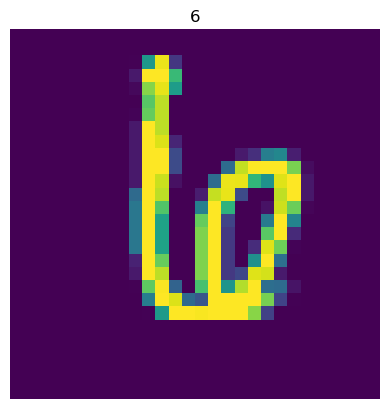

In [53]:
plt.imshow(X_train[21].reshape(28,28))
plt.axis("off")
plt.title(str(Y_train[21]))
plt.savefig('graph.png')
plt.show()

In [54]:
class dig(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 512, kernel_size=7, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(512, 256, kernel_size=5, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3=nn.Conv2d(256,64,kernel_size=3,padding=1)
        self.relu3=nn.ReLU()
        
        self.classifier = nn.Sequential(
            nn.Linear(5*5*64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self,input):
        input=input.to(torch.float32)
        #print(input.shape)
        output=self.conv1(input)
        output=self.relu1(output)
        output=self.pool1(output)
        
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.pool2(output)
        
        output=self.conv3(output)
        output=self.relu3(output)
        
        
        output=output.view(output.size(0), -1)
        
        output=self.classifier(output)
        return output
    
        

In [55]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_val = torch.tensor(Y_val, dtype=torch.long)
X_test = torch.FloatTensor(X_test)

In [56]:
model=dig().to('cuda')


In [57]:
optimiser=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [58]:
train_count=42000*0.8
test_count=42000*0.2

In [60]:
num_epochs = 100
batch_size = 128
best_accuracy=0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].unsqueeze(1).to('cuda')
        labels = Y_train[i:i+batch_size].to('cuda')
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
    
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            inputs = X_val[i:i+batch_size].unsqueeze(1).to('cuda')
            labels = Y_val[i:i+batch_size].to('cuda')
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    if (epoch+1%10==1):
        print(f"Epoch {epoch+1} Train Loss: {(train_loss/len(X_train)):.4f} Validation Loss: {(val_loss/len(X_val)):.4f} Validation Accuracy: {(val_correct/val_total):.4f}")
    if val_correct/val_total>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=val_correct/val_total


Epoch 1 Train Loss: 0.0002 Validation Loss: 0.0003 Validation Accuracy: 0.9893
Epoch 2 Train Loss: 0.0002 Validation Loss: 0.0003 Validation Accuracy: 0.9895
Epoch 3 Train Loss: 0.0002 Validation Loss: 0.0004 Validation Accuracy: 0.9898
Epoch 4 Train Loss: 0.0002 Validation Loss: 0.0003 Validation Accuracy: 0.9900
Epoch 5 Train Loss: 0.0002 Validation Loss: 0.0004 Validation Accuracy: 0.9888
Epoch 6 Train Loss: 0.0002 Validation Loss: 0.0004 Validation Accuracy: 0.9898
Epoch 7 Train Loss: 0.0002 Validation Loss: 0.0003 Validation Accuracy: 0.9917
Epoch 8 Train Loss: 0.0002 Validation Loss: 0.0004 Validation Accuracy: 0.9893
Epoch 9 Train Loss: 0.0002 Validation Loss: 0.0005 Validation Accuracy: 0.9888
Epoch 10 Train Loss: 0.0002 Validation Loss: 0.0004 Validation Accuracy: 0.9881
Epoch 11 Train Loss: 0.0001 Validation Loss: 0.0004 Validation Accuracy: 0.9886
Epoch 12 Train Loss: 0.0002 Validation Loss: 0.0004 Validation Accuracy: 0.9881
Epoch 13 Train Loss: 0.0001 Validation Loss: 0.00

In [61]:
best_accuracy

0.9935714285714285

In [68]:
checkpoint=torch.load('/kaggle/working/best_checkpoint.model')
model=dig().to('cuda')
model.load_state_dict(checkpoint)
model.eval()
predictions = []

model.eval()

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size].unsqueeze(1).to('cuda')
        outputs = model(batch)
        _,predicted = torch.max(outputs.cpu(), 1)
        predictions.extend(predicted.numpy())
    
submission_df = pd.DataFrame({"ImageId": range(1, len(X_test) + 1), "Label": predictions})
submission_df.to_csv("submission_base.csv", index=False)